In [4]:
from genetic_program import FitnessFunction
from gp_artemis import ExperimentManager
%matplotlib inline
import pandas as pd

class WowFitnessFunction(FitnessFunction):
    _name = "ff_sowow"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent * evaluation.num_sells,

class BenchmarkDiffFitnessFunction(FitnessFunction):
    _name = "ff_benchmarkdiff"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent - evaluation.benchmark_backtest.profit_percent,
    
    
    
experiment_json = {
    "training_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/04/01 00:00:00 UTC",
        "end_time": "2018/06/01 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "validation_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/03/01 00:00:00 UTC",
        "end_time": "2018/03/31 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "fitness_function": "ff_v1",
    "grammar_version": "gv1",
    "num_generations": 3,

    "mating_probabilities": [
        0.4,
        0.5,
        0.6
    ],

    "mutation_probabilities": [
        0.7,
        0.8,
        0.9
    ],

    "population_sizes": [
        500
    ]
}

e = ExperimentManager(experiment_json, read_from_file=False)
e.run_experiments(display_results=False)


INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.8;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.9;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_

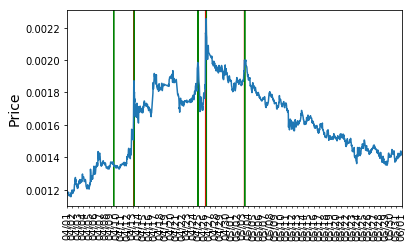

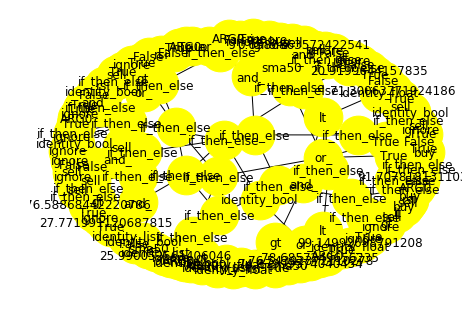

In [5]:
performance_df = e.analyze_and_find_best()

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
performance_df

In [6]:
best = performance_df.iloc[0]['individual']

In [ ]:
str(best)

In [ ]:
from chart_plotter import draw_tree
draw_tree(best)

In [ ]:
print(performance_df.iloc[0].evaluation.get_report())

In [ ]:
print(performance_df.iloc[0].evaluation.benchmark_backtest.get_report())

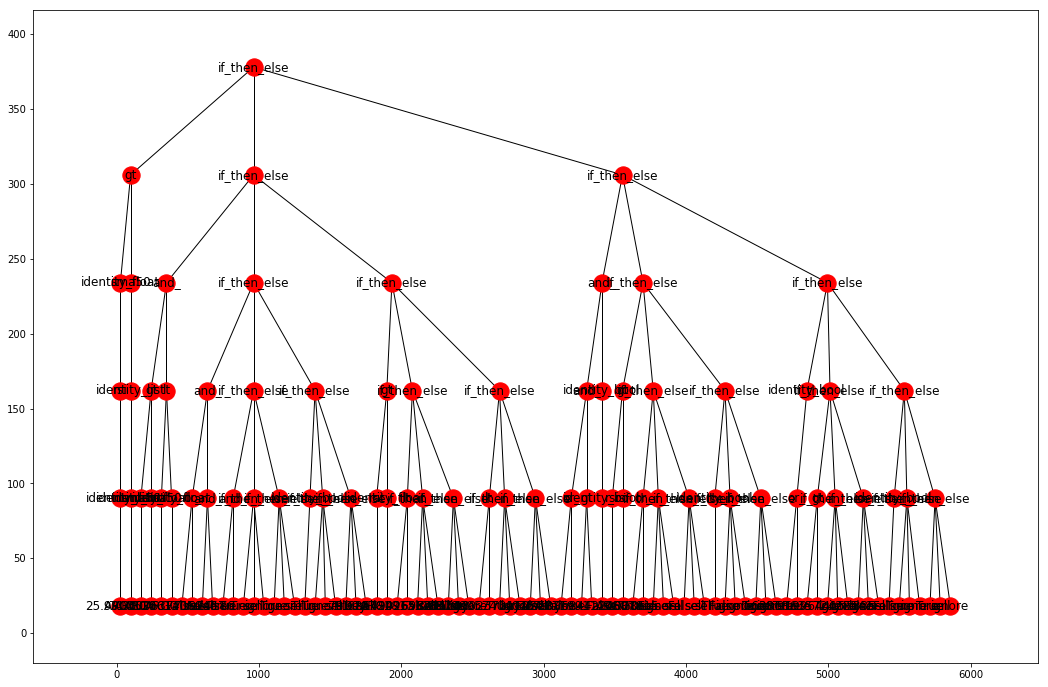

In [7]:
from deap import gp
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pylab
pylab.figure(1,figsize=(18,12))

nodes, edges, labels = gp.graph(best)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [35]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(g)
import json
edited_nodes = [{"name":str(v),"id":int(k)} for (k,v) in labels.items()]
edited_edges = [{"source":item[0], "target":item[1]} for item in edges]
with open('graph.json', 'w') as f:
    json.dump({'nodes': edited_nodes, 'links': edited_edges},
              f, indent=4,)
    #json.dump(data, f, indent=4)



In [43]:
%%html

<div id="d3-container">< /div>

<style>

.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}

< /style>

In [45]:
%%javascript
// We load the latest version of d3.js from the Web.
require.config({paths: {d3: "https://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {

    // Parameter declaration, the height and width of our viz.
    var width = 800,
        height = 600;

    // Colour scale for node colours.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(30)
        .size([width, height]);

    // We select the < div> we created earlier and add an 
    // SVG = Scalable Vector Graphics
    var svg = d3.select("#d3-container").select("svg")
    if (svg.empty()) {
        svg = d3.select("#d3-container").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }

    // We load the JSON network file.
    d3.json("graph.json", function(error, graph) {
        // Within this block, the network has been loaded
        // and stored in the 'graph' object.

        // We load the nodes and links into the force-directed
        // graph and initialise the dynamics.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a < line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a < circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", function(d) {
                // We colour the node depending on the degree.
                if(d.id == 0) return 10; else return 5;
            })
            //.attr("r", 5)  // radius
            .style("fill", function(d) {
                // We colour the node depending on the degree.
                return color(d.name); 
            })
            .call(force.drag);

        // The label each node its node number from the networkx graph.
        node.append("title")
            .text(function(d) { return d.name; });
        
        //node.append("circle")
        //    .attr("r", 5)  // radius
        //    .style("fill", function(d) {
                // We colour the node depending on the degree.
        //        return color(d.name); 
        //    });

        //node.append("text")
        //    .attr("dx", 12)
        //    .attr("dy", ".35em")
        //    .text(function(d) { return d.name });





        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
});

<IPython.core.display.Javascript object>